# Information Pursuit: A Wikispeedia Analysis

This notebook developes an in-depth analysis of the `Wikispeedia` dataset. The goal is to identify the characteristics of human navigation paths, and use this knowledge to produce useful insights on how to assess the difficulty of arbitrary pairs of articles, and the downfalls of common human strategies.

This study requires advanced inspection of the Wikispeedia network of pages, and the results collected from multiple thousand games.

This notebook is divided into four main parts:
1. Wikispeedia network analysis
2. Path Efficiency Analysis
3. Navigation Strategies

In [1]:
%load_ext autoreload
%autoreload 2

### Understanding the data

Before stepping into the analysis, we first describe briefly the data at hand. This also allows us to show a few transformations that have been done to ease data manipulation.

Load and transform some data to make it easy to use

In [2]:
from src.utils.data_utils import load_graph_data

graph_data = load_graph_data()

2024-11-15 23:46:29,622 - src.utils - INFO - loading raw data from tsv files...
2024-11-15 23:46:29,904 - src.utils - INFO - formatting articles...
2024-11-15 23:46:29,907 - src.utils - INFO - formatting categories...
2024-11-15 23:46:29,909 - src.utils - INFO - formatting links...
2024-11-15 23:46:29,966 - src.utils - INFO - formatting paths...
2024-11-15 23:46:30,187 - src.utils - INFO - formatting distance matrix...
2024-11-15 23:46:32,342 - src.utils - INFO - converting distance matrix to dataframe...
2024-11-15 23:46:35,912 - src.utils - INFO - building graph...


Note that 62 edges are present in 'paths_(un)finished.tsv' but not in 'links.tsv':
{('Peak_District', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Miguel_de_Cervantes', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Watercolor_painting', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Batman', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('North_America', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Georgia_(country)', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Glass', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('James_Bond', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Impressionism', 'Édouard_Manet'), ('Tuna', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Household_income_in_the_United_States', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Scientific_classification', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Basilica_of_Santa_Maria_degl

In [3]:
from src.utils.general_utils import describe_dict

describe_dict(graph_data)

Keyword                       | Type (shape)          
------------------------------------------------------
paths_finished                  DataFrame (51318, 9)  
articles                        DataFrame (4604, 1)   
links                           DataFrame (119882, 2) 
shortest-path-distance-matrix   DataFrame (319476, 1) 
categories                      DataFrame (5204, 2)   
paths_unfinished                DataFrame (24875, 9)  
graph                           DiGraph (4604, 119944)


### Why analysing human behaviors

In [4]:
# Show differences between paths and shortest paths

paths_info = graph_data["paths_finished"][["hashedIpAddress", "timestamp", "path_length", "source", "target"]].copy()
paths_info.sort_values(by="timestamp", inplace=True)

# only take first path of every player
paths_info = paths_info.groupby(["source", "target", "hashedIpAddress"], as_index=False).first()

paths_info = paths_info[["source", "target", "path_length"]]
paths_info = paths_info.groupby(["source", "target"]).describe()

paths_info["shortest_distance"] = graph_data["shortest-path-distance-matrix"]["optimal_path_length"]

# remove one special case where shortest_distance is nan
paths_info = paths_info[lambda df: ~df.shortest_distance.isna()]

paths_info

path_length                             \
                                          count       mean       std   min   
source       target                                                          
10th_century 11th_century                   3.0   2.000000  0.000000   2.0   
             Country                        1.0   3.000000       NaN   3.0   
14th_century African_slave_trade            3.0   7.333333  2.081666   5.0   
             Elizabeth_I_of_England         4.0   7.500000  5.744563   4.0   
             Fire                           1.0   4.000000       NaN   4.0   
...                                         ...        ...       ...   ...   
Zirconium    Hebrew_calendar                1.0   5.000000       NaN   5.0   
             Magna_Carta                    1.0   4.000000       NaN   4.0   
             Robinson_Crusoe                1.0  10.000000       NaN  10.0   
             United_Kingdom                 1.0   4.000000       NaN   4.0   
             Ununbium                       1.0   3.000000       NaN   3.0   

                                                            shortest_distance  
                                      25%   50%   75%   max                    
source       target                                                            
10th_century 11th_century             2.0   2.0   2.0   2.0               1.0  
             Country                  3.0   3.0   3.0   3.0               2.0  
14th_century African_slave_trade      6.5   8.0   8.5   9.0               3.0  
             Elizabeth_I_of_England   4.0   5.0   8.5  16.0               2.0  
             Fire                     4.0   4.0   4.0   4.0               3.0  
...                                   ...   ...   ...   ...               ...  
Zirconium    Hebrew_calendar          5.0   5.0   5.0   5.0               3.0  
             Magna_Carta              4.0   4.0   4.0   4.0               3.0  
             Robinson_Crusoe         10.0  10.0  10.0  10.0               4.0  
             United_Kingdom           4.0   4.0   4.0   4.0               2.0  
             Ununbium                 3.0   3.0   3.0   3.0               2.0  

[5585 rows x 9 columns]

<Axes: title={'center': 'Comparison of encountered vs optimal path lengths'}, xlabel='Average path length of players', ylabel='Optimal length'>

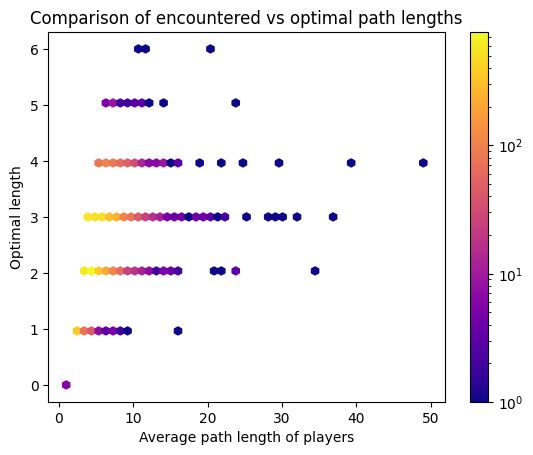

In [5]:
paths_info.plot.hexbin(
	x=("path_length", "mean"),
	y="shortest_distance",
	title="Comparison of encountered vs optimal path lengths",
	xlabel="Average path length of players",
	ylabel="Optimal length",
	gridsize=50,
	bins="log",
	cmap="plasma",
)

In [6]:
from scipy import stats

print(stats.pearsonr(paths_info[("path_length", "mean")], paths_info["shortest_distance"]))

PearsonRResult(statistic=0.48137486194062207, pvalue=5.93e-322)


## Wikispeedia network analysis

We will start our work by analyzing the Wikispeedia graph.

For this, we create a graph of the wikispeedia game where:
- Each node in the graph represents an article
- A directed edge (u, v) exists if there is a hyperlink from article u to article v.
- The weight of an edge (u, v) represents the number of times users navigated from article u to article v.


First, we start by analyzing the main hubs of the wikipedia network. We use the networkx hits function for that.

In [7]:
import networkx as nx
import numpy as np


def compute_hubs(graph):
	hubs = nx.hits(graph, normalized=True)[0]

	distribution = np.array([*hubs.values()])
	mean = np.mean(distribution)
	std = np.std(distribution)

	# check positive outliers in the hub values
	significant_hubs = list(filter(lambda t: t[1] - mean > 8 * std, hubs.items()))
	significant_hubs = sorted(significant_hubs, key=lambda t: t[1], reverse=True)

	return significant_hubs

In [8]:
compute_hubs(graph_data["graph"])

[('United_States', 0.054636586017020934),
 ('Europe', 0.03021574261845886),
 ('North_America', 0.026632556221205264),
 ('Earth', 0.02098938930349936),
 ('United_Kingdom', 0.017696725970577514),
 ('English_language', 0.017075317179954443),
 ('England', 0.016330491109382055),
 ('World_War_II', 0.014540657984766656),
 ('Theatre', 0.011226803810775678)]

Now we want to analyze how often users click on the provided hyperlinks

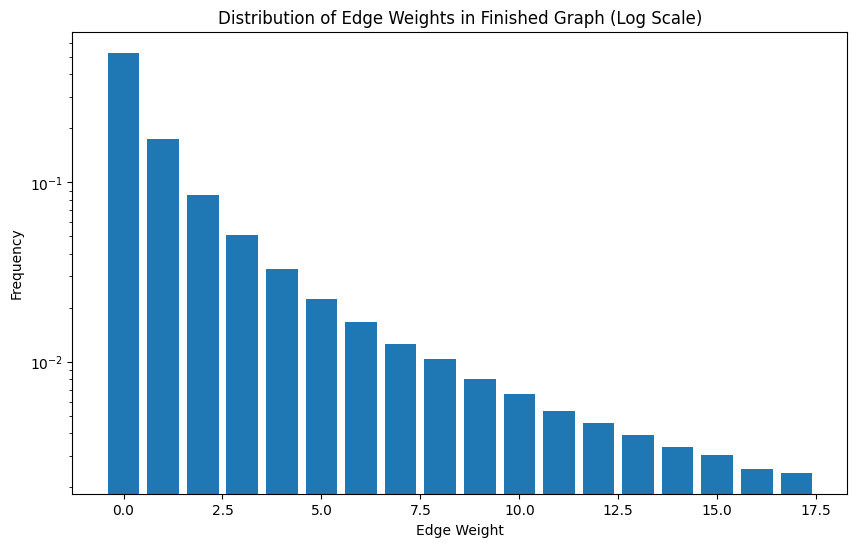

{0: 0.5272043620356166, 1: 0.17350596945241112, 2: 0.08539818582004936, 3: 0.051057160008003734, 4: 0.032865337157340094}


In [33]:
from matplotlib import pyplot as plt

# Extract edge weights
weights = [data["weight"] for _, _, data in graph_data['graph'].edges(data=True)]
num_edges = len(weights)
frequencies = {w: weights.count(w) / num_edges for w in set(weights)}

# Cut off the tail for better visualization
cutoff = 0.0023
filtered_frequencies = {k: v for k, v in frequencies.items() if v >= cutoff}

# Plot filtered_frequencies with log scale
plt.figure(figsize=(10, 6))
plt.bar(filtered_frequencies.keys(), filtered_frequencies.values())
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Edge Weights in Finished Graph (Log Scale)")
plt.show()

# Print only the first 5 frequencies
print(dict(list(frequencies.items())[:5]))

As we can see in the above graph, 52% of the hyperlinks were never clicked by any user, 17% of the hyperlinks were clicked only once and 8% of the hyperlinks were clicked twice. Let's take a closer look at that.

Below are the 20 most clicked hyperlinks by any user

In [10]:
import pandas as pd

edges: list[int] = [(u, v, data["weight"]) for u, v, data in graph_data['graph'].edges.data()]
edges = pd.DataFrame(edges, columns=["from", "to", "weight"]).sort_values("weight", ascending=False).reset_index(drop=True)
edges.iloc[:20]

,from,to,weight
0,Brain,Computer_science,681
1,Animal,Mammal,652
2,North_America,United_States,651
3,Europe,United_Kingdom,600
4,Communication,Telephone,539
5,United_States,President_of_the_United_States,528
6,Lion,Zebra,474
7,Mammal,Zebra,470
8,United_Kingdom,England,463
9,England,Europe,456


Now we will analyze the in-degree of the articles. 

The in-degree of an article is the number of hyperlinks pointing towards that article

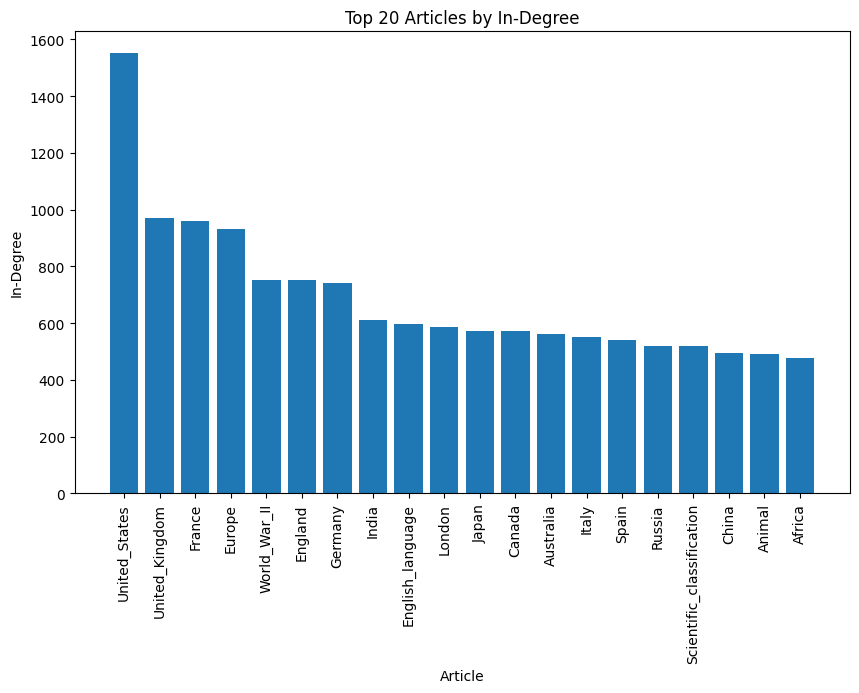

In [11]:
in_degrees = pd.DataFrame(graph_data['graph'].in_degree, columns=["article", "inDegree"])
in_degrees_sorted = in_degrees.sort_values("inDegree", ascending=False).iloc[:20]

plt.figure(figsize=(10, 6))
plt.bar(in_degrees_sorted["article"], in_degrees_sorted["inDegree"])
plt.xlabel("Article")
plt.ylabel("In-Degree")
plt.title("Top 20 Articles by In-Degree")
plt.xticks(rotation=90)
plt.show()

Now we will enumerate the articles with in-degree 0. There are no hyperlink pointing towards these articles and they can never be reached from another article. Those articles are also called orphan articles.

In [12]:
in_degrees.query("inDegree == 0")

,article,inDegree
0,Áedán_mac_Gabráin,0
4,Óengus_I_of_the_Picts,0
5,€2_commemorative_coins,0
34,2005_Hertfordshire_Oil_Storage_Terminal_fire,0
36,2005_Lake_Tanganyika_earthquake,0
...,...,...
4566,Yellowhammer,0
4575,Yotsuya_Kaidan,0
4576,You're_Still_the_One,0
4580,"Yungay,_Peru",0


As we can see, there are 465 unreachable articles.

Now let us analyze the out degrees of the nodes. The out-degree of an article is the number of hyperlinks in that article.

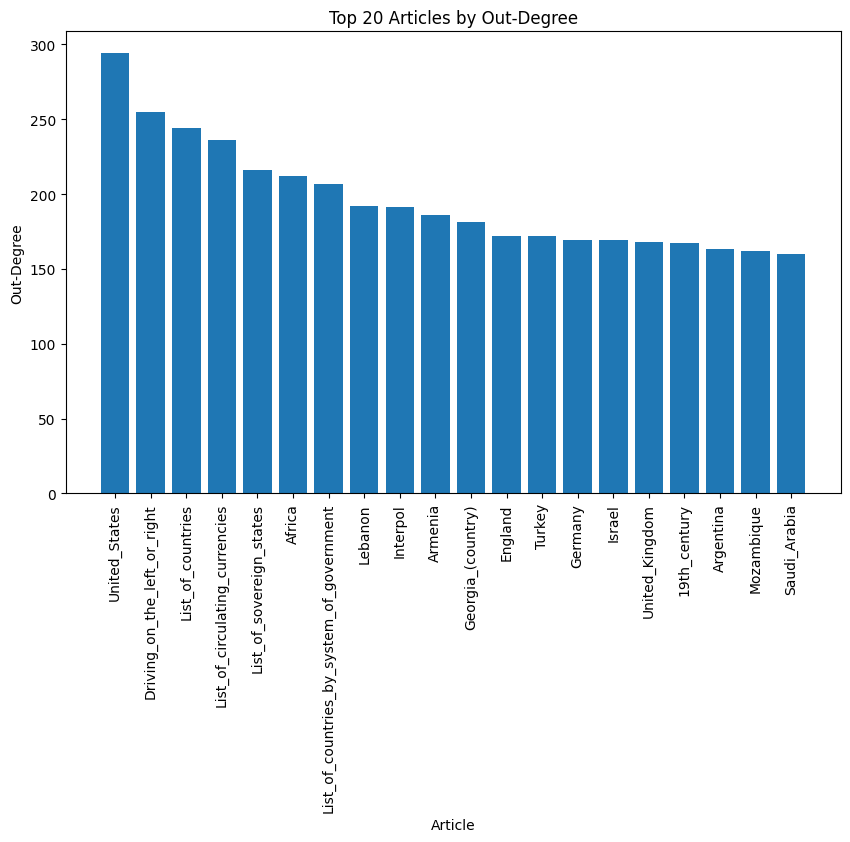

In [13]:
out_degrees = pd.DataFrame(graph_data['graph'].out_degree, columns=["article", "outDegree"])
out_degrees_sorted = out_degrees.sort_values("outDegree", ascending=False).iloc[:20]

plt.figure(figsize=(10, 6))
plt.bar(out_degrees_sorted["article"], out_degrees_sorted["outDegree"])
plt.xlabel("Article")
plt.ylabel("Out-Degree")
plt.title("Top 20 Articles by Out-Degree")
plt.xticks(rotation=90)
plt.show()

In [14]:
out_degrees.query("outDegree == 0")

,article,outDegree
441,Badugi,0
970,Color_Graphics_Adapter,0
1210,Directdebit,0
1231,Donation,0
1237,Douglas_DC-4,0
1257,Duchenne_muscular_dystrophy,0
2351,Klinefelter's_syndrome,0
2530,Local_community,0
2543,Lone_Wolf_(gamebooks),0
3108,Osteomalacia,0


There are no node with out-degree 0. Every article has at least one hyperlink in it.

##### Community Detection

It can be interesting to explore how articles are connected to each other. Community analysis is a powerful tool for uncovering hidden structures in the Wikipedia graph, revealing what group of articles form communities, i.e. group of nodes that are densely connected internally. For that, we use the Leiden algorithm, a community-detection algorithm that works well for huge directed graph.

The detected communities can also help us further analyze players' behaviors by studying how they navigate across communities.

In [15]:
import leidenalg
import igraph as ig

communities = leidenalg.find_partition(
	ig.Graph.from_networkx(graph_data['graph']), leidenalg.RBConfigurationVertexPartition, n_iterations=20, seed=5
)
node_names = {i: node for i, node in enumerate(graph_data['graph'].nodes())}
for i, community in enumerate(communities):
    if len(community) > 5:
	    print(f"Community {i}, {len(community)}: {[node_names[node] for node in community]}")

Community 0, 885: ['Åland', 'Édouard_Manet', '€2_commemorative_coins', '10th_century', '11th_century', '12th_century', '13th_century', '14th_century', '15th_century', '16th_century', '1755_Lisbon_earthquake', '17th_century', '1896_Summer_Olympics', '18th_century', '19th_century', '1st_century', '1st_century_BC', '20th_century', '2nd_century', '3rd_century', '4th_century', '5th_century', '6th_century', '7th_century', '8th_century', '9th_century', 'A_Wrinkle_in_Time', 'A_cappella', 'Aachen', 'Aarhus', 'Abkhazia', 'Able_Archer_83', 'Abraham_Goldfaden', 'Abstract_art', 'Accountancy', 'Achilles', 'Achilles_tendon', 'Actuary', 'Adam_Smith', 'Adolf_Hitler', 'Adriaen_van_der_Donck', 'Aesthetics', 'Agamemnon', 'Age_of_Enlightenment', 'Agnosticism', 'Akhenaten', 'Albigensian_Crusade', 'Albrecht_Dürer', 'Albrecht_Rodenbach', 'Alcibiades', 'Aleksandr_Pushkin', 'Aleksandr_Vasilevsky', 'Aleksey_Arakcheyev', 'Alexander_the_Great', 'Alfred_Nobel', 'Allegory_in_the_Middle_Ages', 'Amish', 'Amsterdam', '

Below are the detected communities:
- Community 0 - **Europe 🇪🇺**. This community includes articles related to European countries, cities, landmarks, and notable figures.
- Community 1 - **Biology 🌱**. Comprising articles on animals, plants, and various natural sciences.
- Community 2 - **Americas 🌎**. This community covers a wide range of topics related to the american continent, including countries, historical events, presidents, and prominent figures.
- Community 3 - **Africa and Asia 🌍**. This community contains articles about countries, history, and cultures across Africa, Asia, and South America.
- Community 4 - **United Kingdom 🇬🇧**. Articles within this community delve into British history, culture, politics, notable figures, and cities.
- Community 5 - **Astronomy, chemistry, physics and maths ⚛️**. This community brings together articles on celestial bodies, the periodic table and physics and maths.
- Community 6 - **Computer Science 🤖**. Our favorite one, here we can find articles about programming languages, operating systems, ...
- Community 7 - **Tennis 🥎**. A small community of 24 articles, all about Tennis.

## Path Efficiency Analysis

In this section, we conduct a Path Efficiency Analysis to evaluate various navigation strategies in the Wikispeedia network. Our objective is to understand user navigation behaviors by examining how efficiently users navigate through articles, considering factors like backtracking, exploration, temporal patterns, and reliance on popular "hub" articles.


   - Network and Path Structure Analysis
   - Navigation Strategy Analysis
   - Statistical Analysis of Navigation Strategies
   - Predictive Model Analysis
   - Temporal Patterns

#### Instructions to Rerun the Code

The analysis taking quite some time to generate, we load here some precomputed data to regenerate the data yourself, run (but pay attention need to change the directory in the next cell due to change in timestep): 

```bash
python3 src/scripts/generate_path_analysis.py

In [16]:
# Loading of our analysis results and needed imports

import json
from PIL import Image
from IPython.display import display

with open('data/generated/plaintext_analysis/analysis_20241115_184429/analysis_report.json', 'r') as f:
    analysis = json.load(f)
with open('data/generated/plaintext_analysis/analysis_20241115_184429/path_statistics.json', 'r') as f:
    path_stats = json.load(f)
with open('data/generated/plaintext_analysis/analysis_20241115_184429/statistical_results.json', 'r') as f:
    stats = json.load(f)

1. Network and Path Structure Analysis

In [17]:
# Load network metrics
network_metrics = analysis['network_analysis']['basic_metrics']

print("Network Structure:")
print(f"Nodes (Articles): {network_metrics['nodes']:,}")
print(f"Edges (Links): {network_metrics['edges']:,}")
print(f"Network Density: {network_metrics['density']:.4f}")
print(f"Average Clustering: {network_metrics['avg_clustering']:.4f}")
print(f"Average Path Length: {network_metrics['avg_path_length']:.2f}")


Network Structure:
Nodes (Articles): 4,604
Edges (Links): 124,486
Network Density: 0.0059
Average Clustering: 0.3416
Average Path Length: 3.18


In our Wikipedia network:
- **Nodes (4,604)**: Each node represents a Wikipedia article
- **Edges (124,486)**: Each edge represents a hyperlink from one article to another
  - For example: If article "Physics" has a link to "Energy", there's an edge Physics → Energy
  - These are directed edges (A → B doesn't mean B → A exists)

- Density = actual edges / maximum possible edges
- Maximum possible edges = n * (n-1) for directed graph with n nodes
- Our density of 0.0059 means:
  - Only 0.59% of possible connections exist
  - For reference, a fully connected network would have density = 1
  - This sparsity is typical for real-world networks

- Finally, clustering measures how well articles' neighbors are connected to eachother. 0.3416 means about 34% of possible connections between neighbors exist, which indicates articles tend to form well connected local groups, and also demonstrates some sort of topical clustering (related articles link to eachother)
- The average path length is 3.18 demonstrating how many articles hops were needed until finishing a path

2. Navigation Strategy Analysis

In [18]:
print("Navigation Strategy Success Rates:")
for strategy, rate in path_stats['success_by_strategy'].items():
    print(f"{strategy}: {rate:.2%}")

Navigation Strategy Success Rates:
Direct: 68.37%
Exploratory: 36.89%
Hub-focused: 50.88%
Mixed: 68.34%


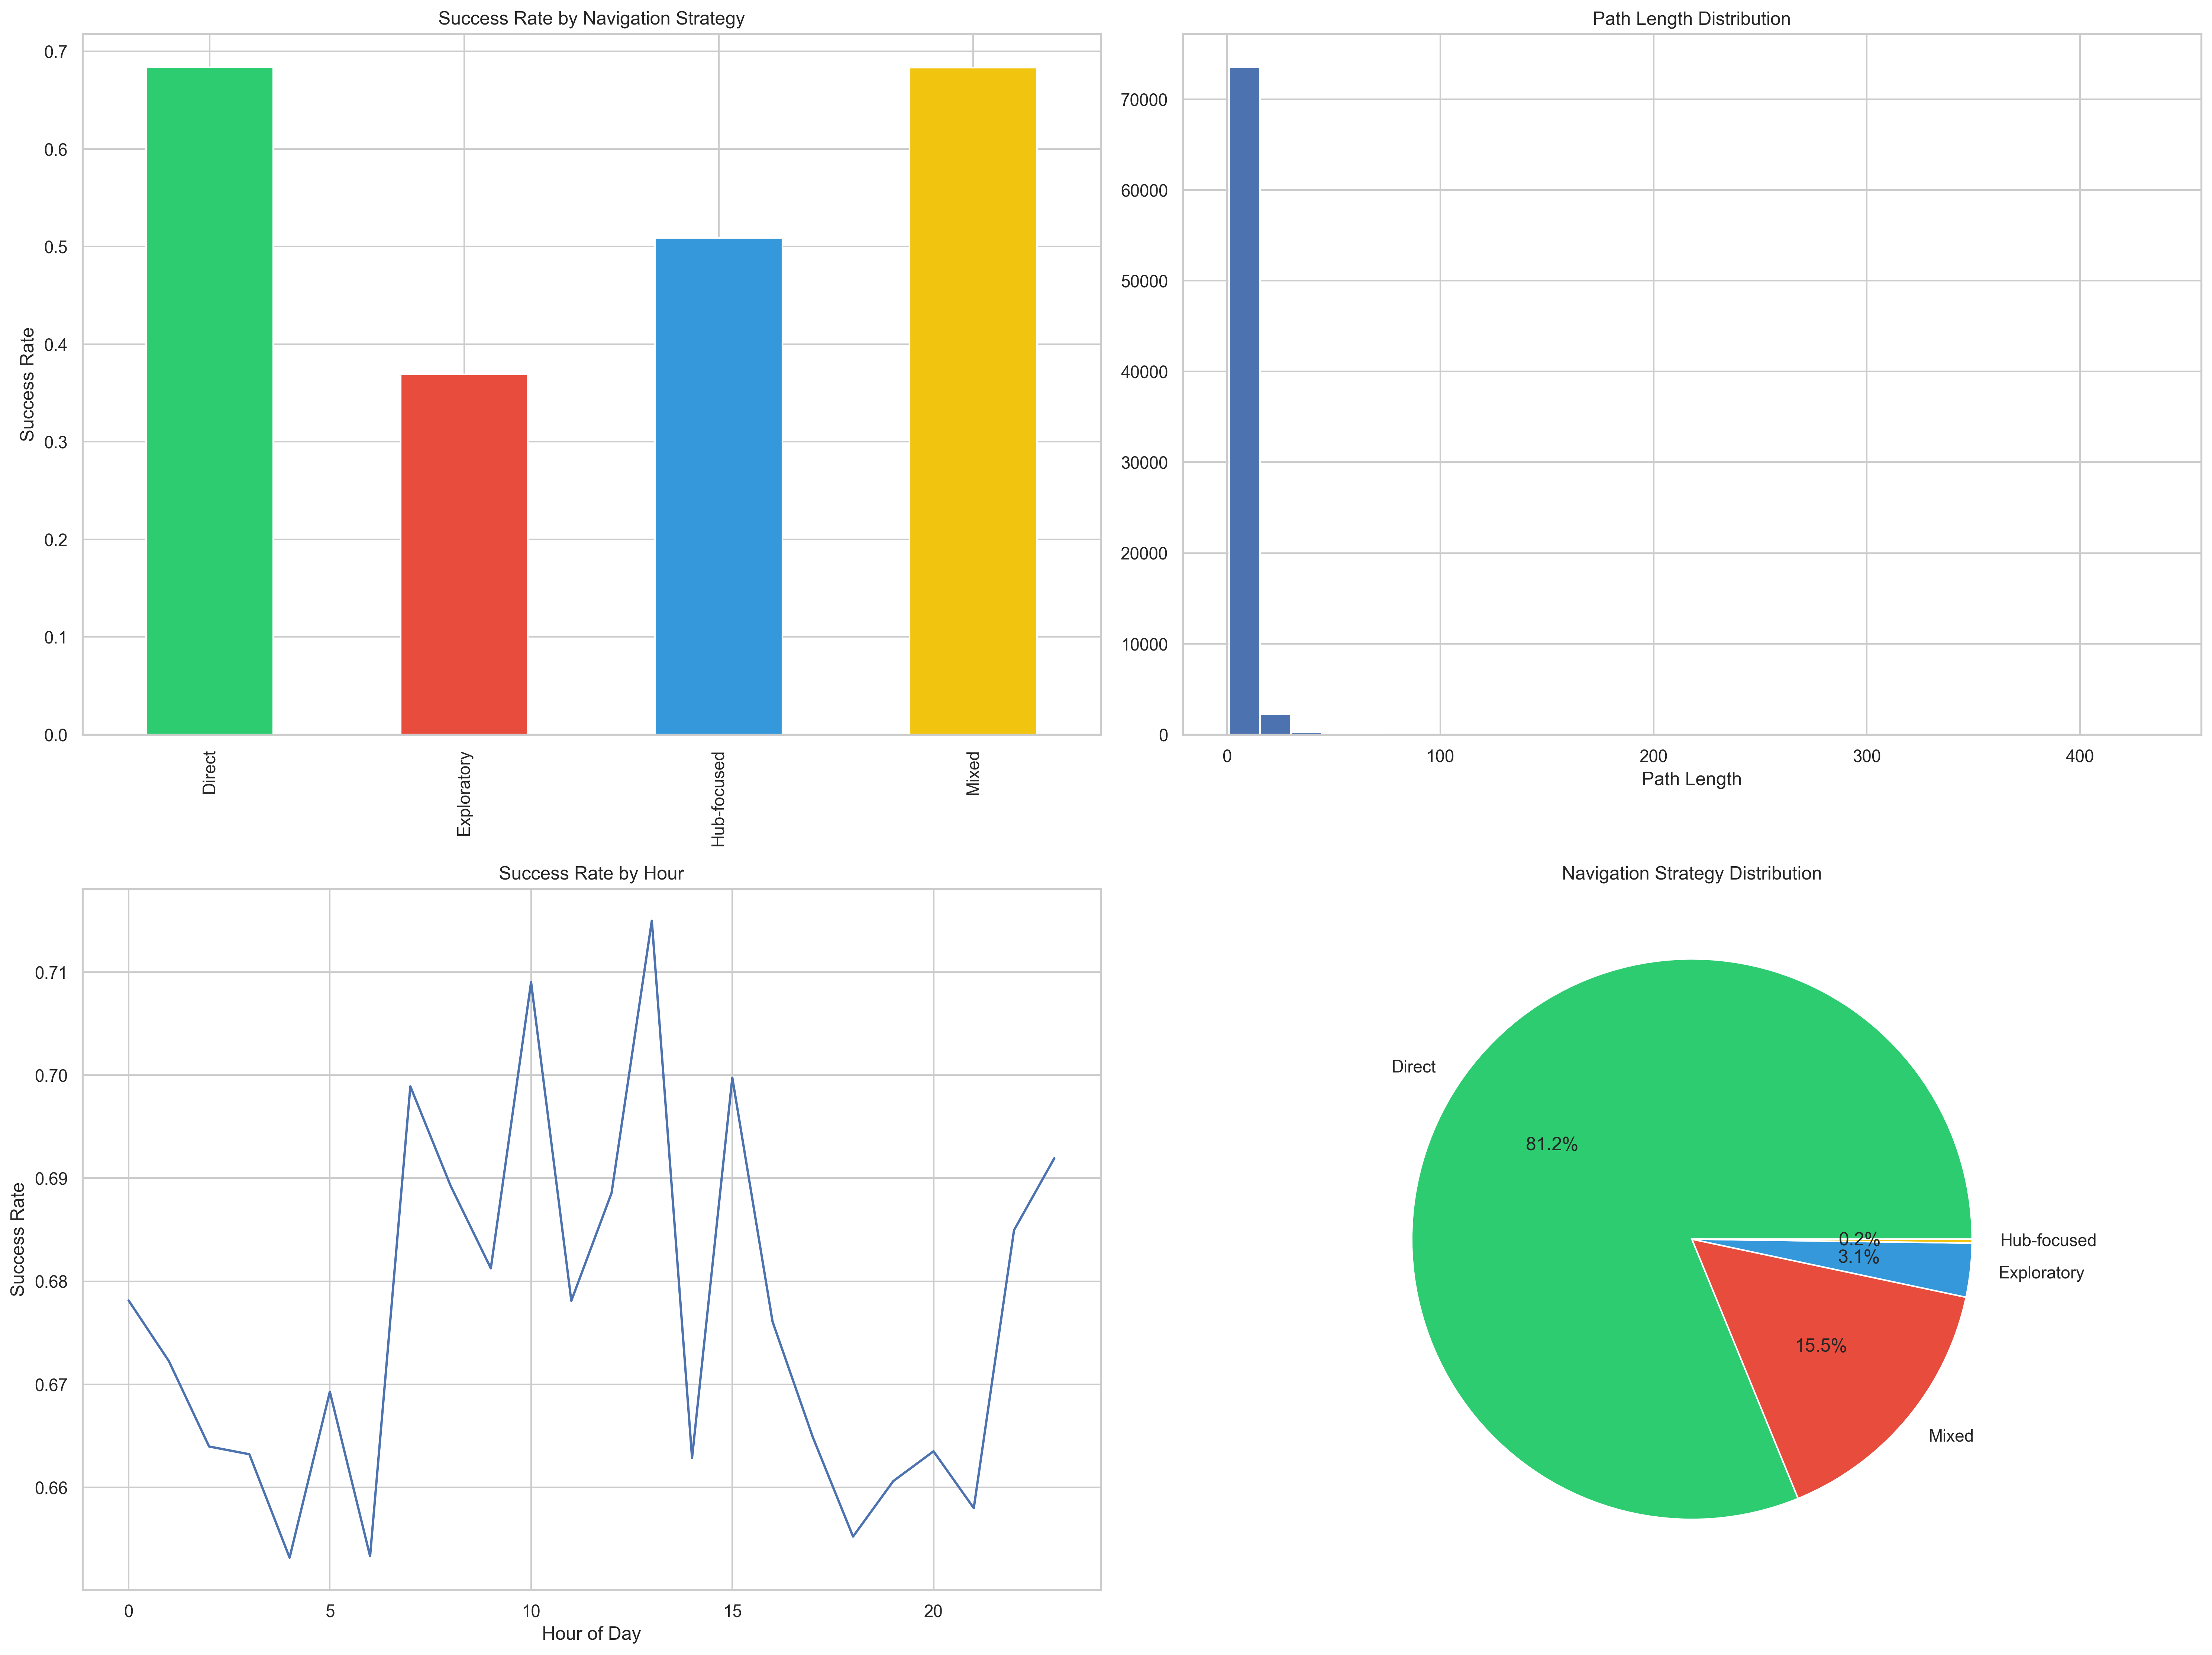

In [19]:
img = Image.open('data/generated/plaintext_analysis/analysis_20241115_184429/navigation_patterns.png')
display(img)

- First we introduce **Path efficiency** is calculated as the ratio of unique articles visited to total path length. A high efficiency (close to 1) means the user reached the target with minimal detours.

- Now we introduce 4 strategies:
    - Direct: A path is classified as Direct if there is no backtracking, and the path efficiency is high (> 0.8)
    - Exploratory: The backtracking ratio (calculated as backtrack_count / path_length) is high (>= 0.3)
    - Hub-focused: The hub usage ratio (calculated as hub_usage / path_length) is above 0.5. Hubs are calculated according to the top 20 hubs, and hub usage is just the sum of the usage of hubs per path
    - Mixed: a path that do not fall in any of the other categories

- Now Direct and Mixed strategies have the highest success rates (around 68%), indicating that users benefit from minimal backtracking or a balanced approach. Exploratory has the lowest success rate (~37%), showing that backtracking frequently leads to a lower hit rate. Finally hub-focused success rate lies between the two (50.88%) meaning reliance on central nodes (with high pagerank value) is somewhat effective.

- From the plots above, we can see that the majority of paths are very short, with a steep drop-off beyond low path lengths. This indicates users often reach their targets quickly without a lot of navigation. As for the success rate by the hour we can see that between 8 and 15 we get the highest success rate showing that this time of the day would probably lead to highest success. At last, most users (81.2%) use straightfoward direct paths with no backtracking (15.5%) and follow a mixed startegy while exploratory and Hub-focused are rare (<4%) implying that users do not rely heavily on backtracking or hubs alone.

3. Statistical Analysis of Navigation Strategies

In [20]:
strategy_test = stats['strategy_analysis']

print("Strategy Effectiveness Test:")
print(f"Chi-square value: {strategy_test['chi2']:.2f}")
print(f"P-value: {strategy_test['p_value']:.2e}")
print(f"Effect size: {strategy_test['effect_size']:.4f}")

Strategy Effectiveness Test:
Chi-square value: 1051.91
P-value: 9.85e-228
Effect size: 0.1175


- We went a little deeper and proposed the hypothesis H0 that we will try to reject: All navigation strategies have the same success rate (strategy choice doesn't affect navigation success). An alternate hypothesis H1: Strategy choice affects navigation success. We performed a chi-square test of independence with Cramer's V to analyze the relationship between navigation strategies and success. Based on the stastics we got Chi-square = 1051.91 (very large), P-value ≈ 9.85e-228 (extremely small) and Effect size = 0.117 (small to moderate), thus we reject our null hypothesis and prove that Strategy choices (Direct, Exploratory, Hub-focused or Mixed) do indeed affect success.

In [21]:
semantic_test = stats['semantic_analysis']
print("Semantic Proximity Test Results:")
print(f"Test name: {semantic_test['test_name']}")
print(f"P-value: {semantic_test['p_value']:.2e}")
print(f"Effect size (Cohen's d): {semantic_test['effect_size']:.4f}")
print(f"Sample size: {semantic_test['sample_size']:,}")

Semantic Proximity Test Results:
Test name: Semantic Proximity Test
P-value: 4.62e-174
Effect size (Cohen's d): 0.2366
Sample size: 70,968


In this test, we analyzed whether the semantic relationship between the **starting and target articles** affects navigation success. 

1. **Article Content Processing**:
   - Used full text content from plaintext articles
   - Applied TF-IDF (Term Frequency-Inverse Document Frequency) vectorization
   - Limited to top 5000 terms for efficiency
   - Removed common stop words

2. **Distance Computation**:
   - For each path, we only consider first and last article
   - Example: path = ['Physics', 'Atom', 'Energy', 'Nuclear_power'] 
     * Only compute similarity between 'Physics' and 'Nuclear_power'
   - Used cosine similarity between TF-IDF vectors
   - Higher similarity = Lower semantic distance

Now we use t tests to test the mean of two independent groups that we have : 
**Successful paths**: Average semantic distance between start-target articles for successful navigations
**Failed paths**: Average semantic distance between start-target articles for failed navigations

Our Hypotheses are:
- **H₀**: $μ_{successful}$ = $μ_{failed}$ 
  * Mean semantic distances are equal between successful and failed paths
- **H₁**: $μ_{successful}$ ≠ $μ_{failed}$
  * Mean semantic distances differ between successful and failed paths

Now based on our semantic proximity test results an extremely low p-value (4.62e-174) with a moderate effect size (Cohen's d = 0.237) we thus reject our null hypothesis and can say that the average semantic relationship between start and target articles differs significantly between successful and failed navigation attempts.

4. Predictive Model Analysis

Model Performance Metrics:
ROC AUC Score: 0.855
Cross-validation Score: 0.844 ± 0.003

Feature Importance (ordered by absolute impact):
avg_time_per_click     -8.376 (abs: 8.376)
unique_articles         2.111 (abs: 2.111)
path_length            -1.752 (abs: 1.752)
semantic_coherence     -0.603 (abs: 0.603)
backtrack_count         0.485 (abs: 0.485)
path_efficiency         0.391 (abs: 0.391)
hub_usage_ratio         0.113 (abs: 0.113)


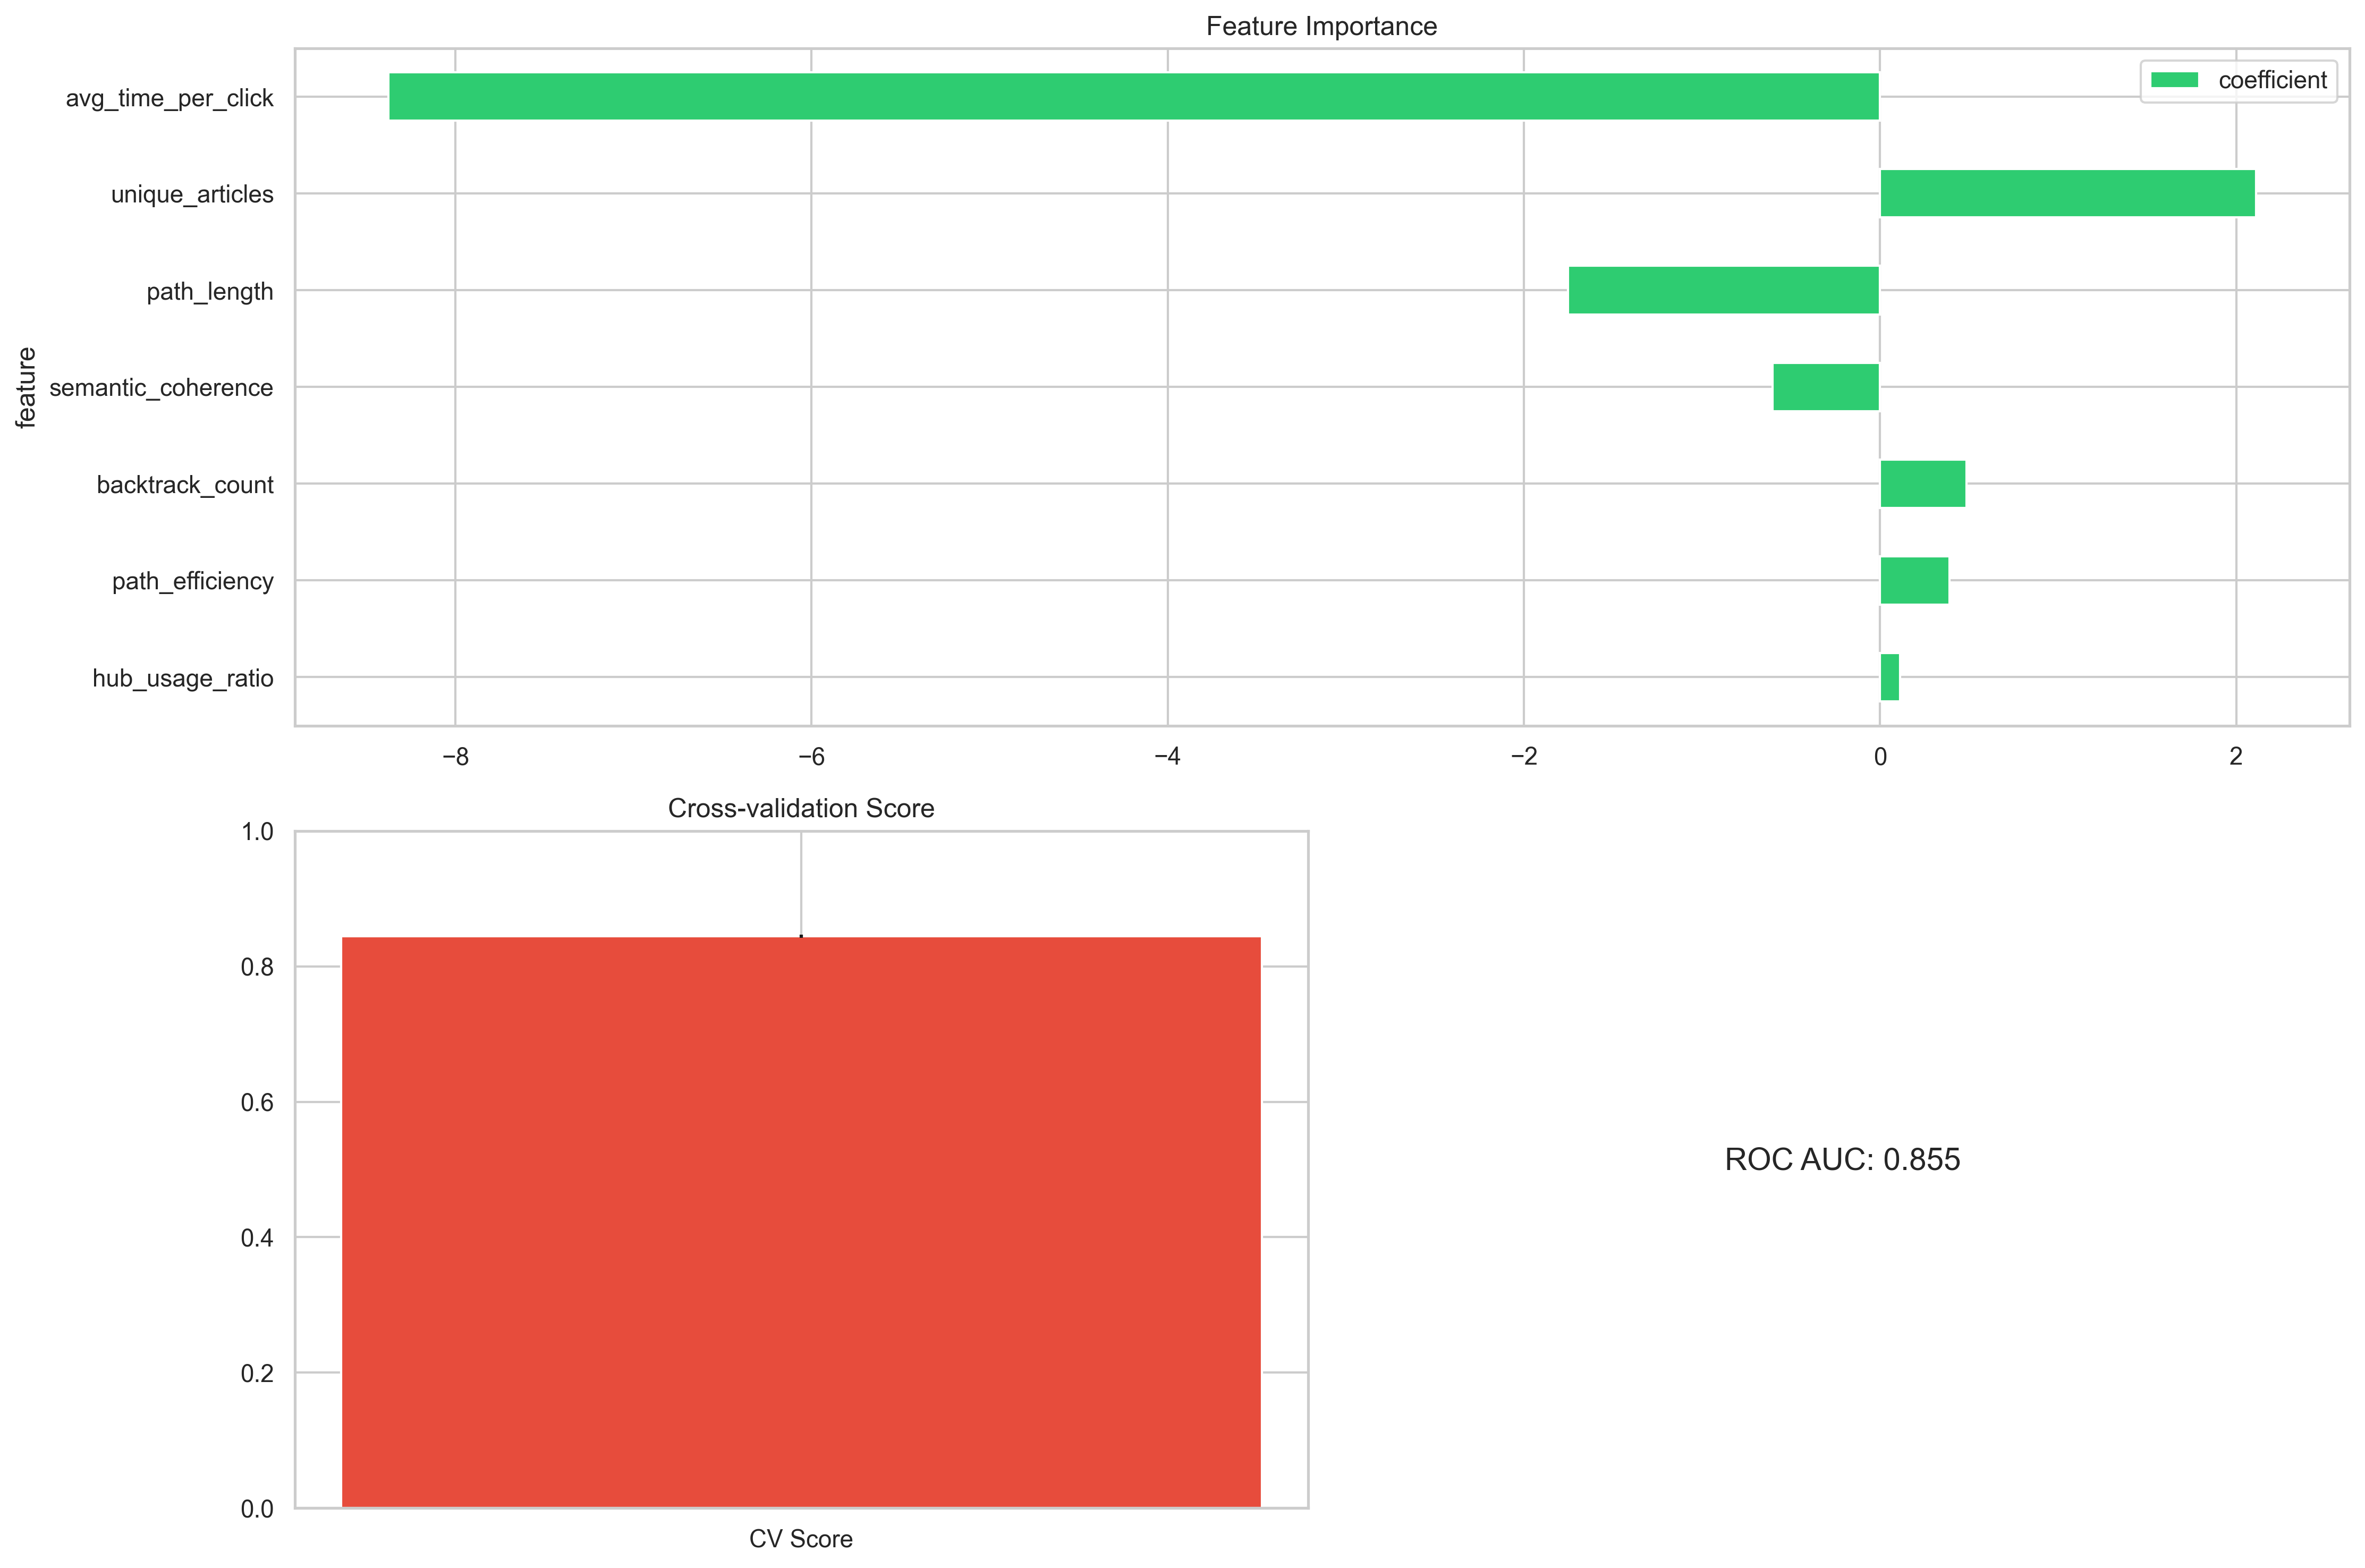

In [22]:
# Show the model results
model_results = stats['model_performance']

print("Model Performance Metrics:")
print(f"ROC AUC Score: {model_results['roc_auc']:.3f}")
print(f"Cross-validation Score: {model_results['cv_scores']['mean']:.3f} ± {model_results['cv_scores']['std']:.3f}")

import pandas as pd
features_df = pd.DataFrame(model_results['feature_importance'])
features_df = features_df.sort_values('abs_importance', ascending=False)

print("\nFeature Importance (ordered by absolute impact):")
for _, row in features_df.iterrows():
    print(f"{row['feature']:20} {row['coefficient']:>8.3f} (abs: {row['abs_importance']:.3f})")

# Show the model performance plot too
display(Image.open('data/generated/plaintext_analysis/analysis_20241115_184429/model_performance.png'))

We developed a logistic regression model to predict whether a user will successfully reach their target article in Wikispeedia navigation. This model will help understand what factors contribute to successful navigation strategies. Our data split is 80-20$ train-test set across all paths in the dataset.

The features we used in the model and their significance:
1. avg_time_per_click: Measures the speed of navigation (average time per article visit). Calculated by dividing duration_in_seconds by path_length. This is the strongest predictor (coefficient of -8.376), indicating faster navigation leads to higher success, 
2. unique_articles: Captures exploration by counting different articles in a path. It is calculated as the count of unique articles visited in the path (ignoring backtracking markers). Its coefficient is 2.111 demonstrating that ,more unique articles improve success
3. path_length: Represents total navigation steps. Calculated as the length of the path list. Shorter paths are generally more successful (coefficient of -1.752).
4. semantic_coherence: Measures how similar the content between consecutive articles. Calculated by taking the average of the cosine similarity between consecutive articles (using TF-IDF vectors from the content of the articles). Surprisingly, lower coherence slightly correlates with success (coefficient of -0.603).
5. backtrack_count: Tracks the number of times users return to previous articles. Calculated by counting backtrack markers (<) in the path. The coefficient weight is 0.485 which could suggest that strategic backtracking can positively impact success.
6. path_efficiency: Indicates efficiency by using the ratio of unique articles to total steps. Calculated as unique_articles / path_length. Efficient paths slightly increase success probability (coefficient of 0.391).
7. hub_usage_ratio: Measures reliance on hubs (or popular articles in the sense of pagerank). Calculated as the ratio of top hub articles visited (if available) to path length. This feature has a minimal impact on success (0.113 coefficient)

Finally, we applied 5-fold cross-validation on the training data to estimate the model's consistency. The cross-validation accuracy score was 0.844 ± 0.003, indicating that the model is consistent across the folds. On the test set, we used the ROC AUC and got a value of 0.855 which demonstrate that our model is effective at predicting successful navigation paths


5. Temporal Patterns

Daily Success Rates:
Friday: 67.52%
Monday: 68.78%
Saturday: 67.26%
Sunday: 65.03%
Thursday: 66.05%
Tuesday: 66.49%
Wednesday: 69.50%

Hourly Success Rates (Highs and Lows):
Highest Success Rate - Hour 13: 71.50%
Lowest Success Rate - Hour 4: 65.32%


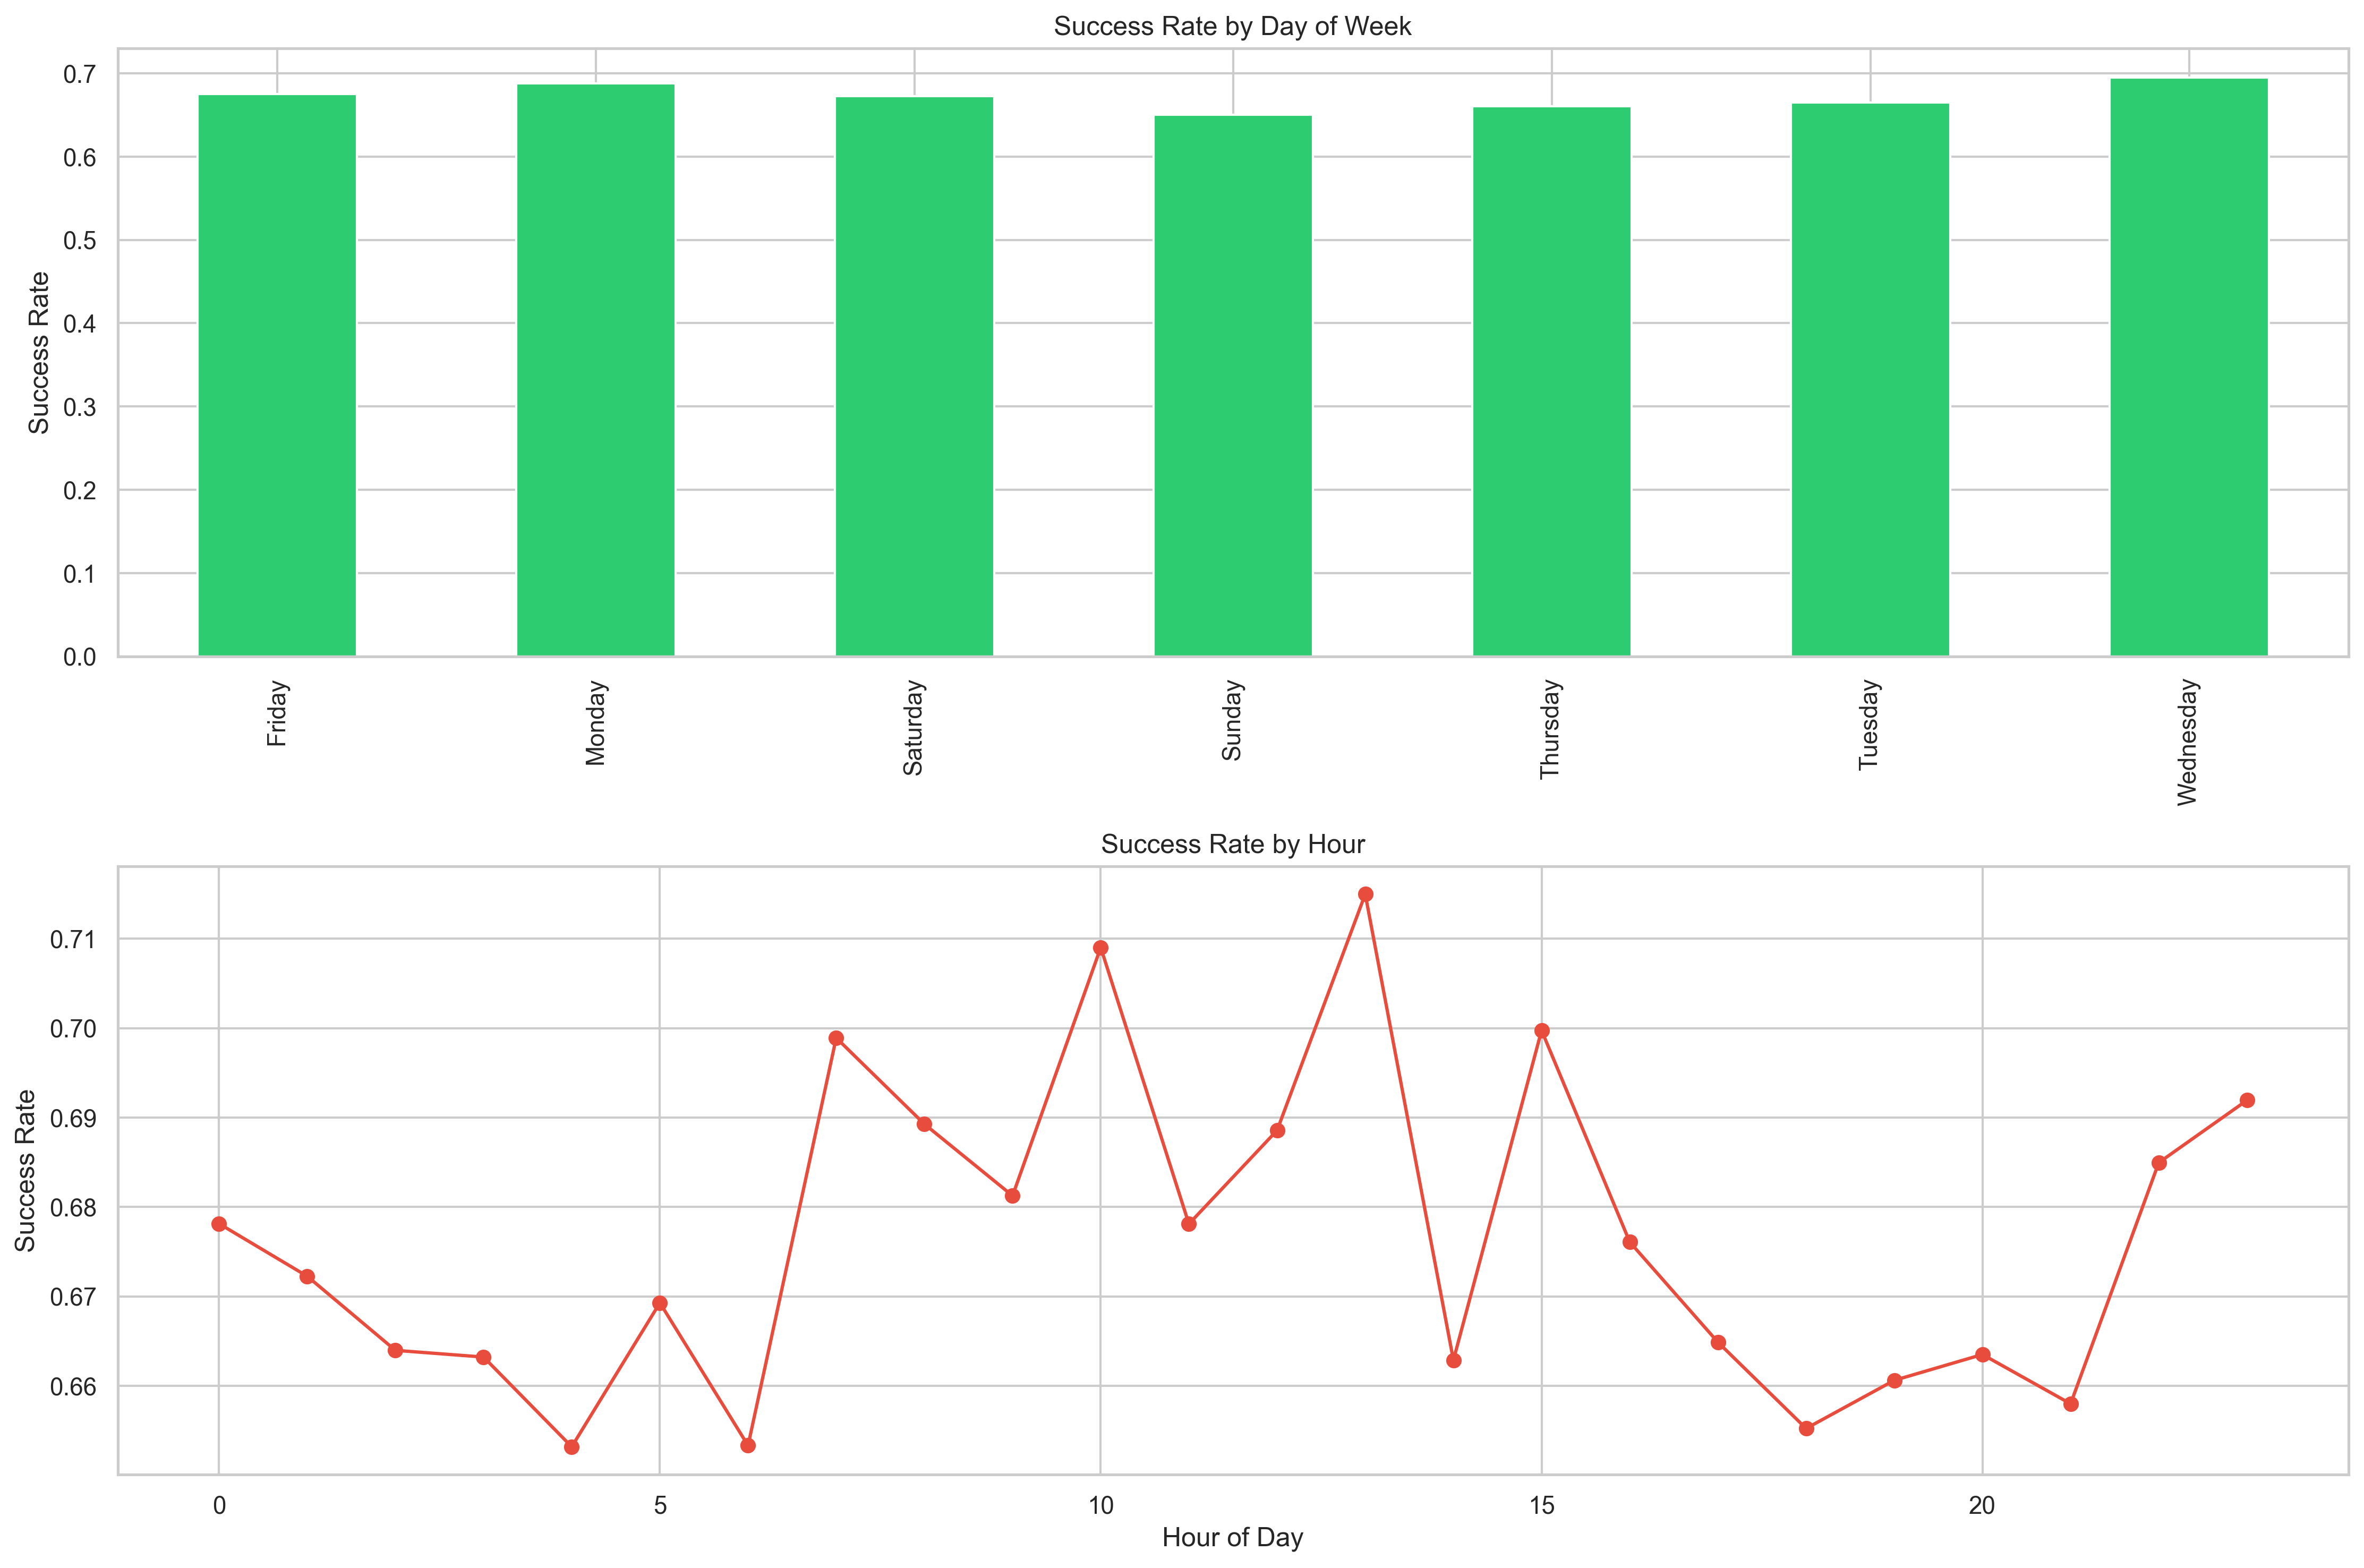

In [23]:
temporal_patterns = analysis["temporal_patterns"]
daily_success_rate = temporal_patterns["daily_success_rate"]
hourly_success_rate = temporal_patterns["hourly_success_rate"]

# Analysis of Temporal Patterns in Navigation Success

print("Daily Success Rates:")
for day, rate in daily_success_rate.items():
    print(f"{day}: {rate:.2%}")

print("\nHourly Success Rates (Highs and Lows):")
highest_hour = max(hourly_success_rate, key=hourly_success_rate.get)
lowest_hour = min(hourly_success_rate, key=hourly_success_rate.get)
print(f"Highest Success Rate - Hour {highest_hour}: {hourly_success_rate[highest_hour]:.2%}")
print(f"Lowest Success Rate - Hour {lowest_hour}: {hourly_success_rate[lowest_hour]:.2%}")

display(Image.open('data/generated/plaintext_analysis/analysis_20241115_184429/temporal_patterns.png'))

Finally, success is consistently high throughout the week, with the highest on Wednesday (69.5%) 
and the lowest on Sunday (65.0%), suggesting that users might have some different behaviors patterns depending on the day. Hourly success rates peak around 10-13 and 15, reaching up to 71.5% at 13:00, 
while the lowest success rates occur early in the morning between 3-5 AM.

### Correlation between rank and remaining path length length

We want to determine whether players get better or worse as they progress within a single game, where better means finding the target in the least possible amount of clicks.
To explain our method, let's consider two hypothetical games:
- The first game is from `Bird` to `Sun`.
- The second game is from `Telephone` to `Sun`, but at some during the game, the player visits the article `Bird`.
In which of the two games will the player reach `Sun` from `Bird` in the least amount of clicks?
Now, for all the games where the target was `Sun` and where the player visited the article `Bird` at some point during the game, do the players reach `Sun` from `Bird` slower if their encounter with `Bird` happens later in the game?

To answer this question we will perform the following computation:

For every ordered pair of distinct articles $A$ and $B$, we consider the games where $B$ is the target,
and we study the correlation between the **rank**, that is, the moment in the game where $A$ is visited,
(ignoring those games where $A$ is not visited)
and the **remaining path length** (that is, the number of clicks the player takes to reach $B$ from $A$).

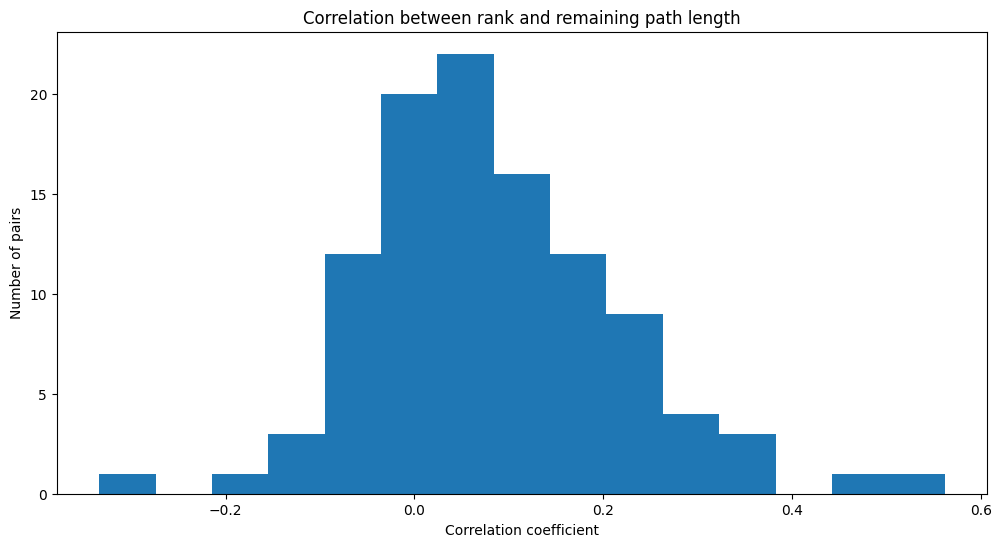

In [24]:
from src.utils.data_utils import compute_correlation_between_rank_and_path_length
from matplotlib import pyplot as plt
import warnings

# Computing correlation coefficients yields RuntimeWarnings when the std is 0
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=RuntimeWarning)
    corr_data = compute_correlation_between_rank_and_path_length(graph_data["paths_finished"])


COUNT_THRESHOLD = 60    # We restrict our analysis to article pairs that have enough instances,
                        # otherwise the correlation coefficient will not be significant enough

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.hist(corr_data.pipe(lambda x: x[x['count'] > COUNT_THRESHOLD])['correlation_coefficient'].values, bins=15, log=False)
ax.set_title("Correlation between rank and remaining path length")
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('Number of pairs');

Although the correlation is not strong for most pairs, we see that there is a slight bias towards the positive side, meaning that the higher the rank, the longer the remaining path length.

In other words, players perform worse (maybe they get tired, or frustrated) the longer the game.

Further analysis could be made using different metrics, such as spearman's rank correlation, which works with non normal data
(it doesn't seem reasonable to assume that the distribution of the ranks is normal) and would allow us to formulate
the null hypothesis that there is relationship between rank and remaining path length.

## Navigation Strategies

It seems quite reasonable to hypothetized that humans navigate the pages of the Wikispeedia website based on relationships existing between the target article concept and the content of the articles found along the way. In order to reason about these semantic relations, humans abstract ideas and form their inner world model, making internalizing concepts efficient and smooth.

In this analysis, we verify if an intuitive top-down approach is indeed the most prevalent strategy of the players.

*Do players have a tendancy to over-utilize hubs of the Wikispeedia networks?*\
*Is this strategy usually paying-off?*

We will explore the above questions for the final report

# Strategy : how to find unrelated specific articles

The game sometimes contains some totally unrelated articles that have no direct links. One human strategy would be to find use more general concepts to bridge these two articles.
For example when browsing from Picasso to Theory of Relativity, it might be easier to go from Picasso to Spain, even if Spain is not closer to Theory of Relativity. Because Spain is a more general article, it might be easier to find a link to Science for example.

To test this hypothesis we first link the articles to their pagerank scores, which we normalize.
After that we will plot the average path and how the generality of the articles behave.

In [25]:
from src.utils.data_utils import load_graph_data
import pandas as pd

# Load the data
graph_data = load_graph_data()
paths_finished = graph_data['paths_finished']

from src.utils.generality import pagerank
graph_pagerank = pagerank(graph_data['graph'])


In [26]:
article_gen_score = graph_pagerank.set_index('Article')['Generality_score']

# Get path finished and filter so that we only keep short paths (other are noise)
paths_finished = graph_data['paths_finished']
paths_finished = paths_finished[paths_finished['path'].apply(len) <= 20]
#Remove < from path (but keep the articles that the person attempted to go to)
paths_finished['path'] = paths_finished['path'].apply(lambda x: [u for u in x if u != '<'])


paths_finished['Generality_score'] = paths_finished['path'].apply(
    lambda path: article_gen_score.loc[path].tolist()
)

/tmp/ipykernel_34617/3330500446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished['path'] = paths_finished['path'].apply(lambda x: [u for u in x if u != '<'])
/tmp/ipykernel_34617/3330500446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished['Generality_score'] = paths_finished['path'].apply(


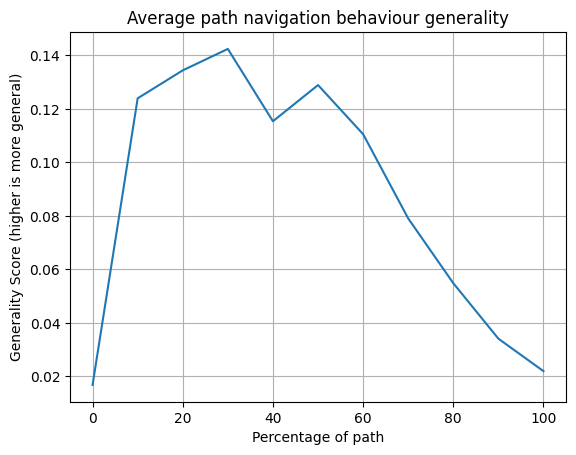

In [27]:
import matplotlib.pyplot as plt
from src.utils.generality import average_path
scores, percent = average_path(10, paths_finished)



plt.plot(percent, scores)
plt.xlabel('Percentage of path')
plt.ylabel('Generality Score (higher is more general)')
plt.title('Average path navigation behaviour generality')
plt.grid(True)
plt.show()

We see that on average, while the first and last articles are very specific, the middle articles are more general, confirming our hypothesis.
We also see that there is a decrease in generality towards the end when the player probably has a specific path in mind of how to join that article

## Link position strategy

Because the players are playing under time pressure, we assume they don't have time to look at the whole articles before making a selection. Therefore we state the hypothesis that players are clicking mostly on the first links that appear on the page.
The links are ordered lexicographically so we need to scan the html files to find the order of the links. Then we will normalize by the number of links on the page and look at the proportion of clicks that happen with the top 20% of links (so for example if there are 20 links on a given page, a click would count towards that quantity if it is on the first 4 links.)


In [28]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.data_utils import load_graph_data
from src.utils.data_utils import get_links_from_html_files

graph_data = load_graph_data()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
all_links_dict = get_links_from_html_files()
for article, links in all_links_dict.items():
    for link in links:
        #Normalize to get relative position
        link['position'] = link['position']/len(links)


starting...


In [30]:
paths_finished = graph_data['paths_finished']
paths_unfinished = graph_data['paths_unfinished']

from src.utils.link_strategy import get_click_positions

click_positions_fin = get_click_positions(paths_finished, all_links_dict)
click_positions_unfin = get_click_positions(paths_unfinished, all_links_dict)

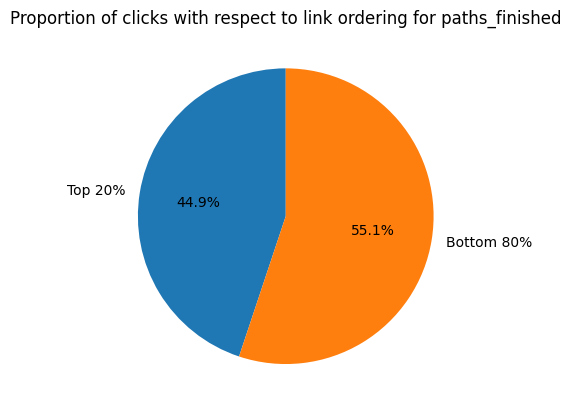

In [ ]:
import matplotlib.pyplot as plt

top_links = [pos for pos in click_positions_fin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_fin if pos > 0.2]


labels = ['Top 20%', 'Bottom 80%']
sizes = [len(top_links), len(otherlinks)]
#Plot results as a pie with percentage, to add precision change x.2f
plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title('Proportion of clicks with respect to link ordering for paths_finished')
plt.show()


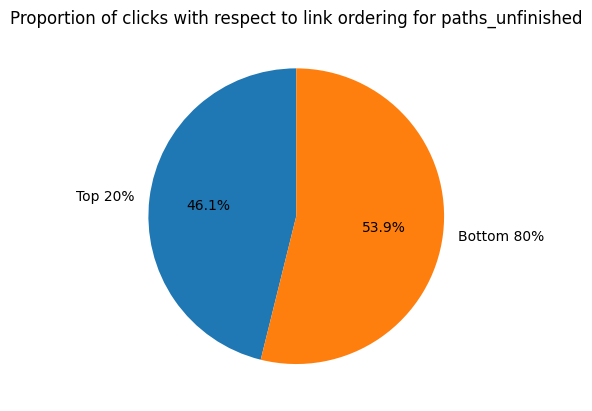

In [ ]:
import matplotlib.pyplot as plt

top_links = [pos for pos in click_positions_unfin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_unfin if pos > 0.2]

labels = ['Top 20%', 'Bottom 80%']
sizes = [len(top_links), len(otherlinks)]
#Plot results as a pie with percentage, to add precision change x.2f
plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title('Proportion of clicks with respect to link ordering for paths_unfinished')
plt.show()


It appears that both paths that are finished and unfinished click mostly on links in the top of the page (45% instead of expected 20% if the players scanned the whole page and articles importance was disseminated at random.) So players employ this strategy that is not reflected in the shortest path matrix since it doesn't take into account the position of the links. Note that the slightly higher percentage of top clicks in paths_unfinished may mean that unsuccessful players are more naive, but this hypothesis needs to be tested more in detail because the difference is so small.


## Conclusion

This analysis of the Wikispeedia dataset has provided valuable insights into human navigation behaviors and the structural properties of the Wikispeedia network. By examining the network's characteristics, we gained a better understanding of the communities, hubs, and connections. The path efficiency analysis revealed patterns in human decision-making, while the study of navigation strategies highlighted the strengths and weaknesses of common approaches.

These findings enhance our understanding of how humans traverse information networks and offer a foundation for developing tools to predict navigation challenges and optimize user experience.